# DATA LOADING

In [1]:
from transformations import Compose, DenseTarget
from transformations import MoveAxis, Normalize01
from customdatasets2 import SegmentationDataSet
from torch.utils.data import DataLoader
from customdatasets import make_mask
from skimage.io import imread
from sklearn.model_selection import train_test_split
import pathlib
import numpy as np
import pandas as pd

df = pd.read_csv("understanding_cloud_organization/train_320.csv")

# root directory
root = pathlib.Path.cwd() / 'understanding_cloud_organization'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
inputs = get_filenames_of_path(root / 'train_images_320')  
true_inputs = []
true_targets = []

shape = (320, 480)


for input in inputs:
    img_name = str(input).split('/')[-1]
    array_input = imread(input)
    true_inputs.append(array_input)
    true_inputs.append(np.fliplr(array_input))
    true_inputs.append(np.flipud(array_input))
    mask = make_mask(df, img_name, shape)
    true_targets.append(mask)
    true_targets.append(np.fliplr(mask))
    true_targets.append(np.flipud(mask))
    
# training transformations and augmentations
transforms = Compose([
    DenseTarget(),
    Normalize01(),
    MoveAxis(),
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    true_inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)


targets_train, targets_valid = train_test_split(
    true_targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

    

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms)


# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=4,
                                 shuffle=False)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=4,
                                   shuffle=False)

dataloaders = {
    'train': dataloader_training,
    'val': dataloader_validation
} 



/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Model

In [2]:
import torch
from resnet_unet import ResNetUNet 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=4)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 320, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
            Conv2d-5         [-1, 64, 160, 240]           9,408
            Conv2d-6         [-1, 64, 160, 240]           9,408
       BatchNorm2d-7         [-1, 64, 160, 240]             128
       BatchNorm2d-8         [-1, 64, 160, 240]             128
              ReLU-9         [-1, 64, 160, 240]               0
             ReLU-10         [-1, 64, 160, 240]               0
        MaxPool2d-11          [-1, 64, 80, 120]               0
        MaxPool2d-12          [-1, 64, 80, 120]               0
           Conv2d-13          [-1, 64, 80, 120]          36,864
           Conv2d-14          [-1, 64, 

# Train

In [3]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=1):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 4
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=7)

cuda:0
Epoch 0/6
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.324414, dice: 0.802479, loss: 0.324414
val: bce: 0.289029, dice: 0.770540, loss: 0.289029
saving best model
11m 4s
Epoch 1/6
----------
LR 0.0001
train: bce: 0.286918, dice: 0.769619, loss: 0.286918
val: bce: 0.281913, dice: 0.761614, loss: 0.281913
saving best model
11m 4s
Epoch 2/6
----------
LR 0.0001
train: bce: 0.275006, dice: 0.759837, loss: 0.275006
val: bce: 0.278565, dice: 0.757441, loss: 0.278565
saving best model
11m 4s
Epoch 3/6
----------
LR 0.0001
train: bce: 0.264789, dice: 0.750840, loss: 0.264789
val: bce: 0.280765, dice: 0.755357, loss: 0.280765
11m 5s
Epoch 4/6
----------
LR 0.0001
train: bce: 0.253040, dice: 0.739853, loss: 0.253040
val: bce: 0.286873, dice: 0.753334, loss: 0.286873
14m 40s
Epoch 5/6
----------
LR 0.0001
train: bce: 0.238278, dice: 0.725539, loss: 0.238278
val: bce: 0.296978, dice: 0.753287, loss: 0.296978
14m 41s
Epoch 6/6
----------
LR 0.0001
train: bce: 0.220751, dice: 0.707976, loss: 0.220751
val: bce: 0.312806, dice: 0.754261, los

# Prediction

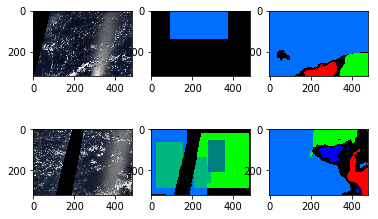

In [6]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import pathlib

random_seed = 42

# root directory
root = pathlib.Path.cwd() / 'understanding_cloud_organization'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
inputs = get_filenames_of_path(root / 'train_images_320')
targets = get_filenames_of_path(root / 'train_images_320_Black_Fish_Gravel_Sugar_Flower')

model.eval()   # Set model to evaluate mode

train_size = 0.8  # 80:20 split
inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

test_dataset = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

test_loader = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=False)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=False)
        
x, y = next(iter(dataloader_training))
true_inputs = x.to(device)
true_labels = y.to(device)

pred = model(true_inputs).cpu()
out_pred = torch.softmax(pred, dim=1).detach()


true_inputs = true_inputs.cpu()
true_labels = true_labels.cpu()



import torchvision.utils
from skimage.io import imread
import numpy as np
import helper

def reverse_transform(inp):
    inp = inp.numpy()
    inp = np.moveaxis(inp, -1, 0)
    inp = np.moveaxis(inp, -1, 0)
    input_asarray = np.clip(inp, 0, 1)
    input_asarray = (input_asarray * 255).astype(np.uint8)
    return input_asarray

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in true_inputs]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x.cpu(), "xD") for x in true_labels]

pred_rgb = [helper.masks_to_colorimg(x, "xD") for x in out_pred]

f, axarr = plt.subplots(2,3)
axarr[0][0].imshow(input_images_rgb[0])
axarr[0][1].imshow(target_masks_rgb[0])
axarr[0][2].imshow(pred_rgb[0])
axarr[1][0].imshow(input_images_rgb[1])
axarr[1][1].imshow(target_masks_rgb[1])
axarr[1][2].imshow(pred_rgb[1])